In [15]:
import findspark
from common.const import DATASET, FILEPATH, STAGING_FILENAME
from common.utils import change_case
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType

In [16]:
findspark.init("/home/ubuntu/spark-3.2.1-bin-hadoop2.7")
spark = SparkSession.builder.appName("basics").getOrCreate()

In [17]:
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

In [18]:
df = spark.read.parquet(
    f"{FILEPATH.TEMP_STAGING_PATH}/{STAGING_FILENAME.DMA}_gbt_importance.parquet"
)
df.show()

+---------------+---------------+-----------------------------+---------+---+----+---------------------+---------------+---------+------------+---------+------------+-----------------------------+--------------+---------------------------+----------------------------+
|carbon_emission|recycling_count|monthly_grocery_bill_quantile|body_type|sex|diet|heating_energy_source|social_activity|recycling|cooking_with|transport|vehicle_type|frequency_of_traveling_by_air|waste_bag_size|vehicle_monthly_distance_km|how_many_new_clothes_monthly|
+---------------+---------------+-----------------------------+---------+---+----+---------------------+---------------+---------+------------+---------+------------+-----------------------------+--------------+---------------------------+----------------------------+
|           4058|              1|                            1|      1.0|1.0| 1.0|                  0.0|            2.0|     12.0|        11.0|      2.0|         5.0|                          1

In [19]:
feature_columns = df.columns.copy()
feature_columns.remove(change_case(DATASET.TARGET))
vec_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
vec_df = vec_assembler.transform(df)
vec_df.show()
vec_df = vec_df.withColumnRenamed(change_case(DATASET.TARGET), "label")

+---------------+---------------+-----------------------------+---------+---+----+---------------------+---------------+---------+------------+---------+------------+-----------------------------+--------------+---------------------------+----------------------------+--------------------+
|carbon_emission|recycling_count|monthly_grocery_bill_quantile|body_type|sex|diet|heating_energy_source|social_activity|recycling|cooking_with|transport|vehicle_type|frequency_of_traveling_by_air|waste_bag_size|vehicle_monthly_distance_km|how_many_new_clothes_monthly|            features|
+---------------+---------------+-----------------------------+---------+---+----+---------------------+---------------+---------+------------+---------+------------+-----------------------------+--------------+---------------------------+----------------------------+--------------------+
|           4058|              1|                            1|      1.0|1.0| 1.0|                  0.0|            2.0|     12.0|

In [20]:
train, test = vec_df.randomSplit([0.8, 0.2])
print(f"train shape: {train.count()}, {len(train.columns)}")
print(f"test shape: {test.count()}, {len(test.columns)}")

train shape: 8066, 17
test shape: 1982, 17


In [22]:
random_forest = RandomForestRegressor(featuresCol="features", maxDepth=6, maxBins=16)
model = random_forest.fit(train)

In [24]:
y_pred = model.transform(test)
valuesAndPreds = y_pred.select(["label", "prediction"])
valuesAndPreds = valuesAndPreds.withColumn("label", col("label").cast(DoubleType()))
valuesAndPreds = valuesAndPreds.rdd.map(tuple)
metrics = RegressionMetrics(valuesAndPreds)
score = {
    "r2": metrics.r2,
    "mse": metrics.meanSquaredError,
    "rmse": metrics.rootMeanSquaredError,
    "mae": metrics.meanAbsoluteError,
}

In [25]:
print("Random Forest Regressor:")
print("\tScore:")
for k, v in score.items():
    print(f"\t\t{k}: {v}")

Random Forest Regressor:
	Score:
		r2: 0.3905421978586552
		mse: 328399.86204367207
		rmse: 573.0618309080375
		mae: 414.25640887579095


In [51]:
feat_imp_list = [
    (feat, float(imp))
    for feat, imp in zip(feature_columns, model.featureImportances.toArray())
]
feat_imp_df = spark.createDataFrame(feat_imp_list, ["feature", "importance"])
feat_imp_df.sort("importance", ascending=False).show()

+--------------------+--------------------+
|             feature|          importance|
+--------------------+--------------------+
|        vehicle_type|  0.4504644037140523|
|frequency_of_trav...|  0.2729060554314762|
|           transport| 0.10565876007971582|
|           body_type|  0.0456095540665155|
|                 sex| 0.02683556512079772|
|           recycling|0.025665739505360823|
|        cooking_with| 0.02087455207450168|
|      waste_bag_size| 0.02025836290585461|
|heating_energy_so...| 0.01852525237487419|
|     recycling_count|0.003817811330376...|
|                diet|0.002399982196399935|
|vehicle_monthly_d...|0.001816410125912116|
|     social_activity|0.001769853395643...|
|how_many_new_clot...|0.001739068138531265|
|monthly_grocery_b...|0.001658629539987...|
+--------------------+--------------------+



<AxesSubplot:xlabel='importance', ylabel='feature'>

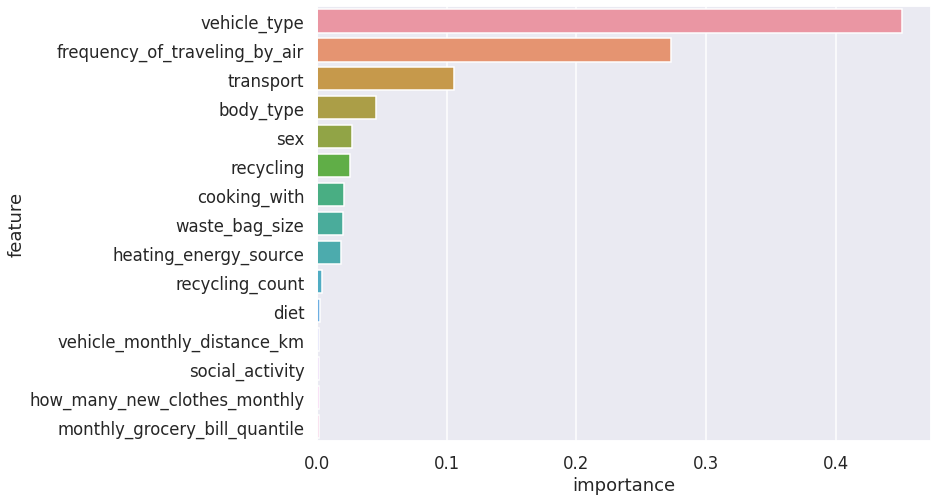

In [59]:
import seaborn as sns
from matplotlib import pyplot as plt

feat_imp_df_pd = feat_imp_df.sort("importance", ascending=False).toPandas()
sns.set_theme(context="talk")
plt.figure(figsize=(11, 8))
sns.barplot(x="importance", y="feature", data=feat_imp_df_pd)

In [61]:
print(model.toDebugString)

RandomForestRegressionModel: uid=RandomForestRegressor_c65e221569a9, numTrees=20, numFeatures=15
  Tree 0 (weight 1.0):
    If (feature 9 in {0.0,1.0})
     If (feature 0 <= 1.5)
      If (feature 12 in {0.0,3.0})
       If (feature 11 in {2.0,3.0})
        If (feature 2 in {0.0,2.0})
         If (feature 8 in {0.0,1.0,3.0,5.0,8.0,9.0,12.0,14.0})
          Predict: 1247.421052631579
         Else (feature 8 not in {0.0,1.0,3.0,5.0,8.0,9.0,12.0,14.0})
          Predict: 1442.7628865979382
        Else (feature 2 not in {0.0,2.0})
         If (feature 8 in {0.0,1.0,8.0})
          Predict: 1417.0277777777778
         Else (feature 8 not in {0.0,1.0,8.0})
          Predict: 1644.9137931034484
       Else (feature 11 not in {2.0,3.0})
        If (feature 3 in {0.0})
         If (feature 8 in {0.0,3.0,5.0,7.0,8.0,9.0,11.0,12.0})
          Predict: 2046.3877551020407
         Else (feature 8 not in {0.0,3.0,5.0,7.0,8.0,9.0,11.0,12.0})
          Predict: 2284.3298969072166
        Else (featu

<AxesSubplot:>

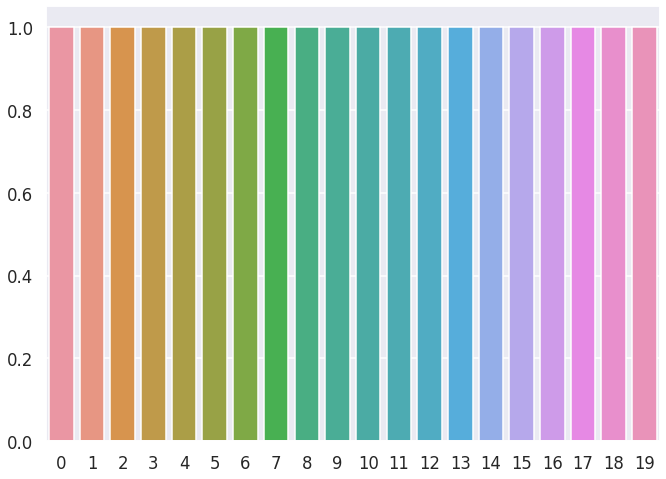

In [67]:
sns.set_theme(context="talk")
plt.figure(figsize=(11, 8))
sns.barplot(x=[i for i in range(len(model.treeWeights))], y=model.treeWeights)